In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from einops import rearrange
from random import randint
from dataset import ImageNetDataset
from vit_trainer import VitTrainer

In [ ]:
vit_trainer = VitTrainer.load_from_checkpoint(
    'logs/vlr-project/xcm1bjxg/checkpoints/last.ckpt'
)

In [21]:
cfg = vit_trainer.cfg
dataset = ImageNetDataset(cfg.data_dir, cfg.image_paths_pkl, cfg.image_size)
indices = torch.randperm(
    len(dataset), generator=torch.Generator().manual_seed(cfg.rand_subset_seed)
)
subset = torch.utils.data.Subset(dataset, indices[: cfg.rand_subset_size])

In [ ]:
idx = randint(0, len(subset) - 1)
print(f'Selected index: {idx}')
img = subset[idx]

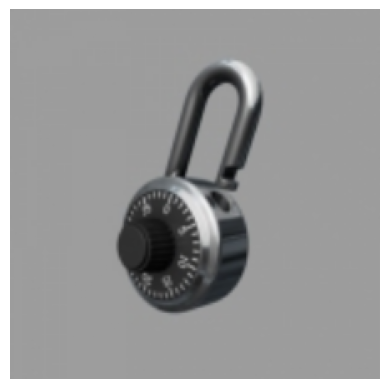

In [38]:
import matplotlib.pyplot as plt
import numpy as np


def denormalize(t, mean, std):
    """
    t   : CxHxW float tensor in [-∞,∞] after Normalize
    mean: sequence of length C
    std : sequence of length C
    """
    mean = torch.as_tensor(mean, dtype=t.dtype, device=t.device)[:, None, None]
    std = torch.as_tensor(std, dtype=t.dtype, device=t.device)[:, None, None]
    return t * std + mean


def show_image(image):
    img = denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = img.clamp(0, 1)
    img = img.permute(1, 2, 0).numpy()

    plt.imshow(img)
    plt.axis('off')
    plt.show()


def show_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, image in zip(axes, images):
        image = image.permute(1, 2, 0).numpy()
        ax.imshow(image)
        ax.axis('off')
    plt.show()


show_image(img)

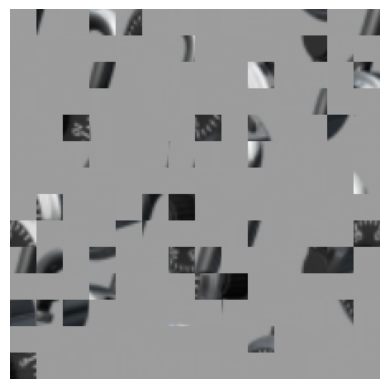

In [ ]:
from utils import permute_image

p_img = permute_image(img, patch_size=cfg.patch_size)
show_image(p_img)

In [43]:
vit = vit_trainer.model
vit = vit.eval()

In [ ]:
with torch.no_grad():
    x = img.unsqueeze(0).to(vit.device)
    x = rearrange(x, 'b c h w -> b (h w) c')
    x = vit.patch_embed(x)
    x = vit.pos_drop(x)
    x = vit.blocks(x)
    x = vit.norm(x)